In [1]:
import os
for dirname, _, filenames in os.walk('jupyter Prgm files/mini project mtech 2nd sem/augmented_output'):
    for filename in filenames:
        os.path.join(dirname, filename)

import os

# Set your working directory
os.chdir("C:\\Users\\harsh\\jupyter Prgm files\\mini project mtech 2nd sem\\augmented_output")

In [2]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries

In [4]:

# Import necessary libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications import VGG19, ResNet50
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
#from tf_explain.core.grad_cam import GradCAM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from tensorflow.keras.applications.vgg19 import preprocess_input

In [5]:
# Loading Dataset
Benign_dir = [r'Benign']

Malignant_Pre_B_dirs = [
    r'[Malignant] Pre-B'
]

Malignant_Pro_B_dirs = [
    r'[Malignant] Pro-B'
]

Malignant_early_Pre_B_dirs = [
    r'[Malignant] early Pre-B'
]

filepaths = []
labels = []
dict_lists = [Benign_dir, Malignant_Pre_B_dirs, Malignant_Pro_B_dirs, Malignant_early_Pre_B_dirs]
class_labels = ['Benign', 'Malignant_Pre-B', 'Malignant_Pro-B', 'Malignant_early Pre-B']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
bloodCell_data = pd.concat([Fseries, Lseries], axis=1)
bloodCell_df = pd.DataFrame(bloodCell_data)
print(bloodCell_df.head())
print(bloodCell_df["labels"].value_counts())



                filepaths  labels
0     Benign\Benign_0.jpg  Benign
1     Benign\Benign_1.jpg  Benign
2    Benign\Benign_10.jpg  Benign
3   Benign\Benign_100.jpg  Benign
4  Benign\Benign_1000.jpg  Benign
labels
Benign                   1500
Malignant_Pre-B          1500
Malignant_Pro-B          1500
Malignant_early Pre-B    1500
Name: count, dtype: int64


In [6]:
print(bloodCell_df.shape)

(6000, 2)


In [7]:
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(train_images, test_size=0.2, random_state=42)

In [8]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(3360, 2)
(1800, 2)
(840, 2)
(4200, 2)


In [9]:
 # Image data generators with adjusted batch size
batch_size = 16

image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_gen.flow_from_dataframe(dataframe=train_set, x_col="filepaths", y_col="labels",
                                      target_size=(244, 244), color_mode='rgb', class_mode="categorical", 
                                      batch_size=batch_size, shuffle=True)

test = image_gen.flow_from_dataframe(dataframe=test_images, x_col="filepaths", y_col="labels",
                                     target_size=(244, 244), color_mode='rgb', class_mode="categorical", 
                                     batch_size=batch_size, shuffle=False)

val = image_gen.flow_from_dataframe(dataframe=val_set, x_col="filepaths", y_col="labels",
                                    target_size=(244, 244), color_mode='rgb', class_mode="categorical", 
                                    batch_size=batch_size, shuffle=False)

# Custom data generator for the ensemble model
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator, batch_size):
        self.generator = generator
        self.batch_size = batch_size
    
    def __len__(self):
        return len(self.generator)
    
    def __getitem__(self, index):
        X, y = self.generator[index]
        return [X, X], y
    
    def on_epoch_end(self):
        self.generator.on_epoch_end()

# Use the custom data generator
train_generator = CustomDataGenerator(train, batch_size)
val_generator = CustomDataGenerator(val, batch_size)
test_generator = CustomDataGenerator(test, batch_size)


Found 3360 validated image filenames belonging to 4 classes.
Found 1800 validated image filenames belonging to 4 classes.
Found 840 validated image filenames belonging to 4 classes.


In [10]:
# Print the classes
classes = list(train.class_indices.keys())
print(classes)

['Benign', 'Malignant_Pre-B', 'Malignant_Pro-B', 'Malignant_early Pre-B']


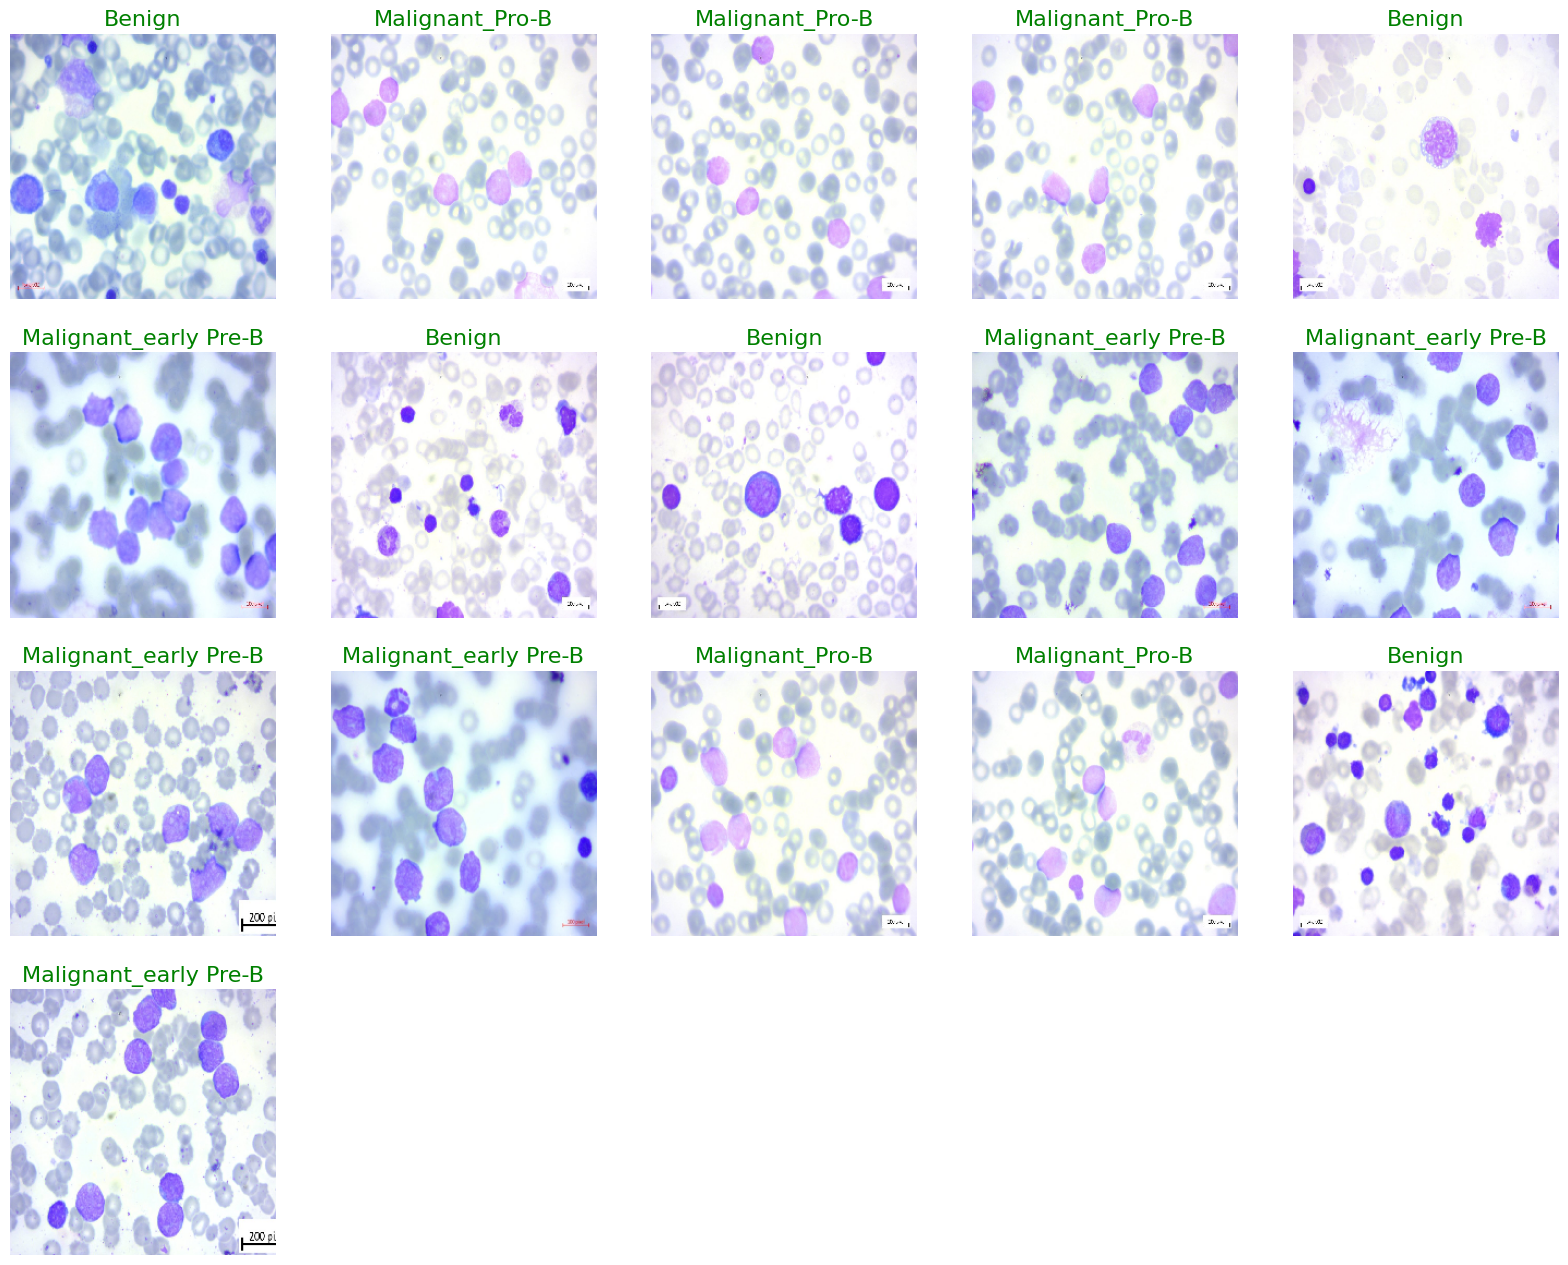

In [11]:
def show_Blood_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_Blood_images(train)

In [31]:
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ----- Define model architecture -----
input_tensor = Input(shape=(244, 244, 3))

vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=(244, 244, 3))
vgg_out = vgg_base(input_tensor)
vgg_out = GlobalAveragePooling2D()(vgg_out)
vgg_out = Dense(512, activation='relu')(vgg_out)

output = Dense(4, activation='softmax')(vgg_out)

model1 = Model(inputs=input_tensor, outputs=output)
model1.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 20,289,092
Trainable params: 20,289,092
Non-trainable params: 0
_______________________________________________

In [32]:
import os
from datetime import datetime
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create directory to store models
os.makedirs("saved_models_vgg19", exist_ok=True)

# Custom callback to save model when val_accuracy > 90%
class SaveBestModel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("val_accuracy")
        if acc and acc > 0.90:
            timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
            filename = f"model_valacc_{acc:.4f}_epoch{epoch+1}_{timestamp}.h5"
            filepath = os.path.join("saved_models_vgg19", filename)
            self.model.save(filepath)
            print(f"✅ Saved model to: {filepath}")

# Learning rate schedule
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=1)

# Image data generators
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_gen.flow_from_dataframe(dataframe=train_set, x_col="filepaths", y_col="labels",
                                      target_size=(244, 244), color_mode='rgb', class_mode="categorical", 
                                      batch_size=8, shuffle=True)

test = image_gen.flow_from_dataframe(dataframe=test_images, x_col="filepaths", y_col="labels",
                                     target_size=(244, 244), color_mode='rgb', class_mode="categorical", 
                                     batch_size=8, shuffle=False)

val = image_gen.flow_from_dataframe(dataframe=val_set, x_col="filepaths", y_col="labels",
                                    target_size=(244, 244), color_mode='rgb', class_mode="categorical", 
                                    batch_size=8, shuffle=False)

# Fit the model
history = model.fit(
    train,
    validation_data=val,
    epochs=10,
    callbacks=[
        annealer,
        EarlyStopping(patience=5, restore_best_weights=True),
        SaveBestModel()
    ]
)


Found 3360 validated image filenames belonging to 4 classes.
Found 1800 validated image filenames belonging to 4 classes.
Found 840 validated image filenames belonging to 4 classes.

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
  2/420 [..............................] - ETA: 25:45 - loss: 0.0466 - accuracy: 0.9375

KeyboardInterrupt: 

In [15]:
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ----- Define model architecture -----
input_tensor = Input(shape=(244, 244, 3))

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(244, 244, 3))
resnet_out = resnet_base(input_tensor)
resnet_out = GlobalAveragePooling2D()(resnet_out)
resnet_out = Dense(512, activation='relu')(resnet_out)

output = Dense(4, activation='softmax')(resnet_out)

model = Model(inputs=input_tensor, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 24,585,732
Non-trainable params: 53,120
__________________________________________

In [16]:
import os
from datetime import datetime
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create directory to store models
os.makedirs("saved_models_vgg19", exist_ok=True)

# Custom callback to save model when val_accuracy > 90%
class SaveBestModel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("val_accuracy")
        if acc and acc > 0.90:
            timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
            filename = f"model_valacc_{acc:.4f}_epoch{epoch+1}_{timestamp}.h5"
            filepath = os.path.join("saved_models", filename)
            self.model.save(filepath)
            print(f"✅ Saved model to: {filepath}")

# Learning rate schedule
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=1)

# Image data generators
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_gen.flow_from_dataframe(dataframe=train_set, x_col="filepaths", y_col="labels",
                                      target_size=(244, 244), color_mode='rgb', class_mode="categorical", 
                                      batch_size=8, shuffle=True)

test = image_gen.flow_from_dataframe(dataframe=test_images, x_col="filepaths", y_col="labels",
                                     target_size=(244, 244), color_mode='rgb', class_mode="categorical", 
                                     batch_size=8, shuffle=False)

val = image_gen.flow_from_dataframe(dataframe=val_set, x_col="filepaths", y_col="labels",
                                    target_size=(244, 244), color_mode='rgb', class_mode="categorical", 
                                    batch_size=8, shuffle=False)

# Fit the model
history = model.fit(
    train,
    validation_data=val,
    epochs=10,
    callbacks=[
        annealer,
        EarlyStopping(patience=5, restore_best_weights=True),
        SaveBestModel()
    ]
)


Found 3360 validated image filenames belonging to 4 classes.
Found 1800 validated image filenames belonging to 4 classes.
Found 840 validated image filenames belonging to 4 classes.

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
420/420 [==============================] - 1751s 4s/step - loss: 0.4225 - accuracy: 0.8667 - val_loss: 17.3057 - val_accuracy: 0.2488 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.00095.
Epoch 2/10
420/420 [==============================] - 1623s 4s/step - loss: 0.1603 - accuracy: 0.9470 - val_loss: 1.6852 - val_accuracy: 0.3988 - lr: 9.5000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009025.
Epoch 3/10
420/420 [==============================] - 3703s 9s/step - loss: 0.0805 - accuracy: 0.9711 - val_loss: 0.3091 - val_accuracy: 0.9048 - lr: 9.0250e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000857375.
Epoch 4/10
420/420 [==============================] - 1803s 4s/step - 

225/225 [==============================] - 192s 840ms/step
Shape of y_true: (1800,)
Shape of y_pred_class: (1800,)


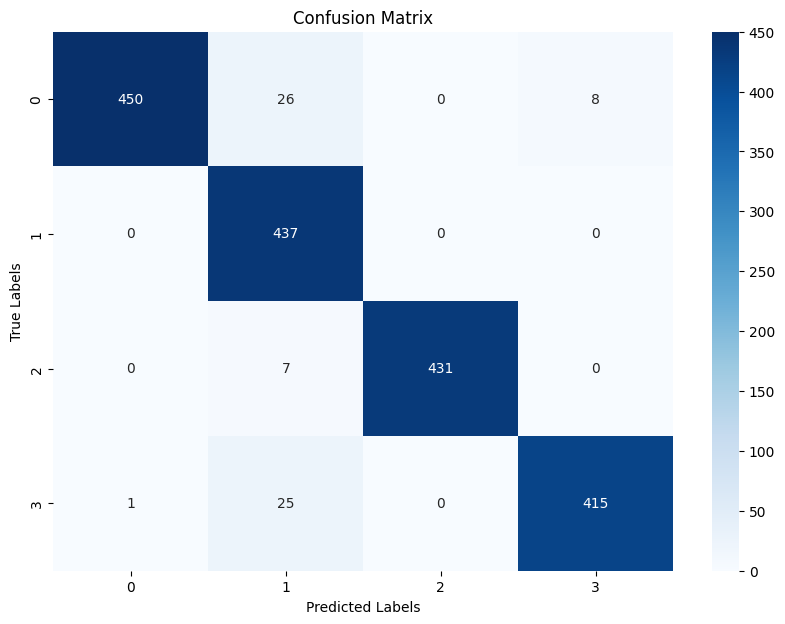

225/225 [==============================] - 191s 848ms/step - loss: 0.1021 - accuracy: 0.9628
Test Loss, Test Accuracy: [0.10207466036081314, 0.9627777934074402]
F1 Score: 0.9632248410993839
Precision: 0.966323535184632
Recall: 0.9627777777777777
Accuracy: 0.9627777777777777
Sample prediction probabilities: [[1.62647723e-07 9.99999404e-01 1.02493791e-09 5.09078745e-07]
 [1.91307641e-04 7.02922000e-03 9.92754281e-01 2.51226702e-05]
 [9.94987011e-01 3.65134678e-03 1.30753505e-10 1.36161922e-03]
 [1.35229275e-05 9.99986053e-01 2.04141216e-07 2.10986428e-07]
 [5.09371830e-07 1.86920092e-01 7.00861946e-09 8.13079417e-01]]
Sample predicted classes: [1 2 0 1 3]


In [17]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define evaluation metric functions for classification
#def dice_coefficient(y_true, y_pred):
#    smooth = 1.0
#    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
#    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
#    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
#    return (2.0 * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

#def intersection_over_union(y_true, y_pred):
#    y_true = tf.cast(y_true, tf.float32)
#    y_pred = tf.cast(y_pred, tf.float32)
#    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=-1)
#    sum_ = tf.keras.backend.sum(tf.keras.backend.abs(y_true) + tf.keras.backend.abs(y_pred), axis=-1)
#    return intersection / (sum_ - intersection)

# Generate predictions from the model
y_pred = model.predict(test)

# Convert predictions to class labels
y_pred_class = np.argmax(y_pred, axis=-1)

# Assuming test.labels provides the true labels in a compatible format
y_true = np.array(test.labels)  # Convert the list to a NumPy array
y_true_class = np.argmax(y_true, axis=-1)

# Ensure y_true_class and y_pred_class are both 1D arrays
if len(y_true.shape) > 1:
    y_true = y_true.flatten()
if len(y_pred_class.shape) > 1:
    y_pred_class = y_pred_class.flatten()

# Check and print the shapes
print(f"Shape of y_true: {y_true.shape}")
print(f"Shape of y_pred_class: {y_pred_class.shape}")

# Ensure that the shapes are consistent
assert y_true.shape == y_pred_class.shape, "Shape mismatch between y_true and y_pred"

# Calculate additional metrics
#dice = dice_coefficient(tf.convert_to_tensor(y_true), tf.convert_to_tensor(y_pred_class))
#iou = intersection_over_union(tf.convert_to_tensor(y_true), tf.convert_to_tensor(y_pred_class))

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class, average='weighted')
precision = precision_score(y_true, y_pred_class, average='weighted')
recall = recall_score(y_true, y_pred_class, average='weighted')
accuracy = accuracy_score(y_true, y_pred_class)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Evaluate the model
results = model.evaluate(test)
print("Test Loss, Test Accuracy:", results)

# Print additional metrics
#print(f"Dice Score: {dice.numpy()}")
#print(f"Intersection over Union: {iou.numpy()}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

# Additional check: inspect the prediction probabilities
print("Sample prediction probabilities:", y_pred[:5])
print("Sample predicted classes:", y_pred_class[:5])



  0%|          | 0/9 [00:00<?, ?it/s]

1/1 [==============================] - 1s 853ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


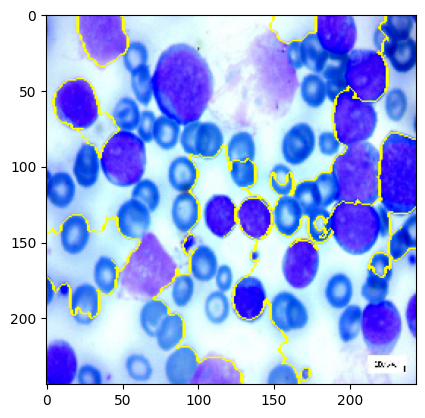

In [30]:
#!pip install lime
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries


explainer = lime.lime_image.LimeImageExplainer()

# Assume you have an index `i` for the image you want to explain
i = 0
image, _ = next(test)  # Get the next batch of images (assuming `test` is an ImageDataGenerator)
explanation = explainer.explain_instance(image[i], model.predict, top_labels=15, hide_color=0, num_samples=9)


# Show explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=15, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.show()

